In [ ]:
from pandas import pd
df = pd.read_csv("/content/Reviews.csv")
print(df)


            Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        HelpfulnessNumerator  HelpfulnessDenominato

In [ ]:
df['sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')
df = df[df['sentiment'] != 'neutral'].reset_index(drop=True)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

df.dropna(subset=['Text'], inplace=True)

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def clean_and_process_text(text):
    # covert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # tokenize
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]

    # lemmatize
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]

    # join
    return ' '.join(lemmas)

# new column
df['cleaned_review'] = df['Text'].apply(clean_and_process_text)

# sample
print("Original Text:", df['Text'].iloc[0])
print("Cleaned Review:", df['cleaned_review'].iloc[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Original Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Cleaned Review: bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# features (X) and target variable (y)
X = df['cleaned_review']
y = df['sentiment']

# split (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initializing the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# fit the vectorizer to the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (420651, 5000)
Shape of X_test_tfidf: (105163, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression model
model = LogisticRegression(solver='liblinear')

# model training
model.fit(X_train_tfidf, y_train)

LogisticRegression(solver='liblinear')

Model Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.68      0.75     16379
    positive       0.94      0.98      0.96     88784

    accuracy                           0.93    105163
   macro avg       0.89      0.83      0.86    105163
weighted avg       0.93      0.93      0.93    105163



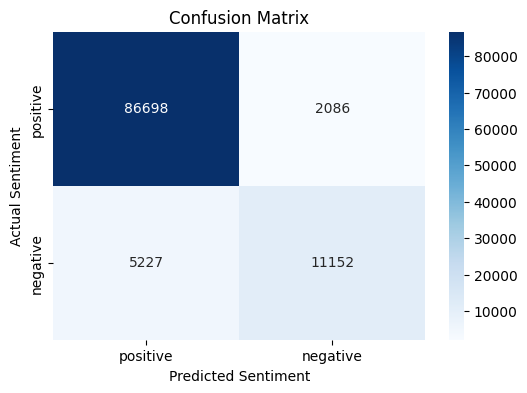

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predictions on the test data
y_pred = model.predict(X_test_tfidf)

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# function to predict the sentiment of a new review
def predict_sentiment(review_text):
    # Apply cleaning and processing to the single input review_text
    cleaned_text = clean_and_process_text(review_text)

    # Vectorize the single cleaned text
    vectorized_text = tfidf_vectorizer.transform([cleaned_text])

    # Make the prediction
    prediction = model.predict(vectorized_text)

    return prediction[0]

positive_review = "This product is fantastic and exceeded all my expectations. I love it!"
negative_review = "I am very disappointed with this item. The quality is terrible."

print(f"'{positive_review}' -> Predicted Sentiment: {predict_sentiment(positive_review)}")
print(f"'{negative_review}' -> Predicted Sentiment: {predict_sentiment(negative_review)}")

'This product is fantastic and exceeded all my expectations. I love it!' -> Predicted Sentiment: positive
'I am very disappointed with this item. The quality is terrible.' -> Predicted Sentiment: negative
